# Classification Models
June 7th, 2022<br>
Adrienne Ko (Adrienne.Ko.23@dartmouth.edu)<br>
Jack Keane (John.F.Keane.22@dartmouth.edu)

The following code was used to test different ML classifiers for predicting gender. These include Random Forest, Ridge classifier, Logistic Regression, Gaussian Naive Bayes, Linear SVC, and SVC. We also used GridSearchCV to optimize parameters for the models.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, precision_score, recall_score, roc_auc_score

import shap
import lime

In [26]:
df = pd.read_csv('./audio_features_final.csv', index_col=0)

In [28]:
# Replace resonance values with the sum of the first and second formants
df['resonance'] = df['f1_diff'] + df['f2_diff']

In [29]:
mcgill = df[df.source == "McGill"]

In [30]:
X = df[['pitch', 'intonation', 'resonance']]
y = df['gender'].apply(lambda x: int(x == 'male'))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:

# Random Forest Classifier

rf_params = {
    # 'n_estimators': [x*x for x in range(3, 12, 2)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, *range(7, 15, 2)]
}
rf = RandomForestClassifier(
    criterion='entropy',
    max_features=2,
    min_samples_leaf=5
) # {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5}
rf = RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=5)
# rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, rf_params, verbose=1)

rf.fit(X_train, y_train)
# print(rf_cv.best_params_)
preds = rf.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9448    0.9545    0.9496       484
           1     0.9584    0.9494    0.9539       534

    accuracy                         0.9519      1018
   macro avg     0.9516    0.9520    0.9518      1018
weighted avg     0.9519    0.9519    0.9519      1018

[[462  22]
 [ 27 507]]


In [40]:
dict(zip(X_test.columns, rf.feature_importances_))

{'pitch': 0.7634785162354933,
 'intonation': 0.16814688811610257,
 'resonance': 0.06837459564840416}

In [42]:
probs = rf.predict_proba(X_test)[:, 1]

In [116]:
# create dataset to inspect misclassifications
missed = df.loc[y_test.index[preds != y_test]]
missed['preds'] = preds[preds != y_test]
missed['probs'] = probs[preds != y_test]
missed.to_csv('./missed_samples.csv')
missed


,filename,gender,sampling_rate,dialect,source,mic_type,pitch,intonation,f1_diff,f2_diff,duration,resonance,preds,probs
684,./audio_data/voxforge/ETT-20090329-typ/wav/a04...,female,48000,American English,VoxForge,laptop built,115.622359,12.686571,-44.491211,3.805176,4.500000,-40.686035,1,0.957843
662,./audio_data/voxforge/anonymous-20090917-dcv/w...,female,48000,American English,VoxForge,laptop built,147.320678,36.787261,-140.665812,-22.184896,3.875000,-162.850708,1,0.991008
123,./audio_data/voxforge/anonymous-20140308-uoq/w...,female,48000,American English,VoxForge,headset mic,124.431792,31.464400,-42.831780,-29.053467,5.750000,-71.885247,1,1.000000
3846,./audio_data/mcgill/MD/MD23_06.wav,male,48000,Canadian English,McGill,stereo mic,129.646912,40.194562,-169.297719,11.153442,2.908396,-158.144277,0,0.017337
3262,./audio_data/voxforge/anonymous-20081027-shw/w...,male,48000,American English,VoxForge,laptop built,121.537593,28.833810,-18.993069,-130.215237,7.499062,-149.208306,0,0.616144
785,./audio_data/voxforge/Anniepoo-20140308-zwy/wa...,female,48000,American English,VoxForge,headset mic,132.099876,46.606794,-102.546555,-154.244308,4.750000,-256.790863,1,0.007965
2766,./audio_data/voxforge/vorcollion-20091013-stb/...,male,48000,American English,VoxForge,desktop boom mic,124.063422,39.600416,-58.618571,-187.267476,4.625000,-245.886047,0,0.000000
1327,./audio_data/voxforge/kendallykay-20110524-qyf...,female,48000,American English,VoxForge,laptop built,150.910349,29.963099,-42.312494,-441.658875,6.750000,-483.971369,1,1.000000
691,./audio_data/voxforge/anonymous-20140308-uoq/w...,female,48000,American English,VoxForge,headset mic,153.287993,36.902183,14.826404,-42.304468,3.750000,-27.478064,1,0.000000
2471,./audio_data/voxforge/Velvet-20131027-fwx/wav/...,female,48000,American English,VoxForge,usb headset mic,146.969171,17.741064,25.164024,-152.453536,7.000000,-127.289512,1,0.993810


In [165]:
import re
def get_user(f):
   res = re.search(r'./audio_data/\w+/(\w+-\w+)-.*', f)
   if not res:
       res = re.search(r'./audio_data/\w+/(\w+)/.*', f)
       return res.group(1)
   return res.group(1)
     
# see if there is a user-based pattern for misclassification
f = missed['filename'].iloc[0]
users = missed['filename'].apply(get_user)
users.value_counts()

(751,)

In [41]:
# create SHAP explainer
explainer = shap.TreeExplainer(rf)
shap.Explainer
shap_test = explainer(X_test)
shap_test.values = shap_test.values[:,:,1]

In [42]:
shap_df = pd.DataFrame(shap_test.values, columns=shap_test.feature_names, index=X_test.index)
shap_df

,pitch,intonation,resonance
1274,-0.385354,-0.075757,-0.033211
4173,0.370437,0.099033,0.027588
2910,0.388855,0.106508,0.002100
2090,-0.397919,-0.070315,-0.016064
348,-0.551444,0.061778,-0.004656
...,...,...,...
3447,0.422291,0.067188,0.014949
2310,-0.343635,-0.129087,-0.013299
1080,-0.190028,-0.077945,-0.078607
952,-0.284842,0.033833,-0.012890


In [43]:
# create dataset to inspect examples where resonance was more important
resonance_important = shap_df['resonance'].abs() > shap_df['pitch'].abs()
resimp_df = df.loc[resonance_important.index[resonance_important]]
resimp_df['pred'] = rf.predict(X_test)[resonance_important]
resimp_df['pred'] = resimp_df['pred'].apply(lambda x: 'male' if x else 'female')
resimp_df['proba'] = rf.predict_proba(X_test)[resonance_important, 1]
resimp_df['correct'] = resimp_df['pred'] == resimp_df['gender']
resimp_df.to_csv('./resonance_important.csv')

In [44]:
# create dataset to inspect examples where intonation was more important
intonation_important = shap_df['intonation'].abs() > shap_df['pitch'].abs()
resimp_df = df.loc[intonation_important.index[intonation_important]]
resimp_df['pred'] = rf.predict(X_test)[intonation_important]
resimp_df['pred'] = resimp_df['pred'].apply(lambda x: 'male' if x else 'female')
resimp_df['proba'] = rf.predict_proba(X_test)[intonation_important, 1]
resimp_df['correct'] = resimp_df['pred'] == resimp_df['gender']
resimp_df.to_csv('./intonation_important.csv')

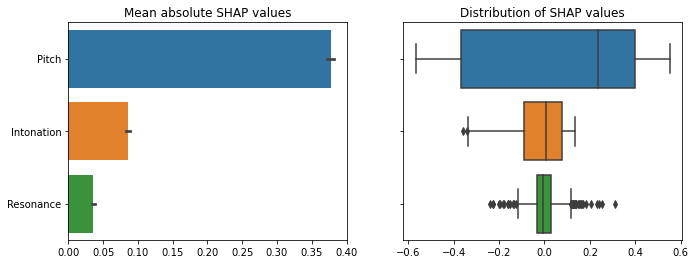

In [56]:
# visualize summary of SHAP values for test set
columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(11,4), sharey=True)
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute SHAP values")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of SHAP values")
ax[0].set_yticklabels(['Pitch', 'Intonation', 'Resonance'])

plt.show()

pitch         0.377462
intonation    0.085314
resonance     0.035943
dtype: float64


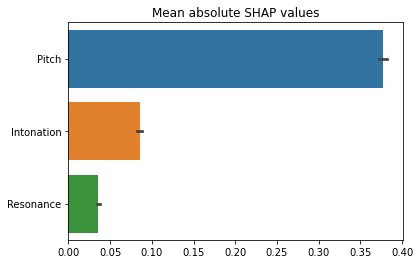

In [68]:
# visualize summary of SHAP values
columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h')
plt.title("Mean absolute SHAP values")
plt.yticks(labels=['Pitch', 'Intonation', 'Resonance'], ticks=[0, 1, 2])

plt.show()

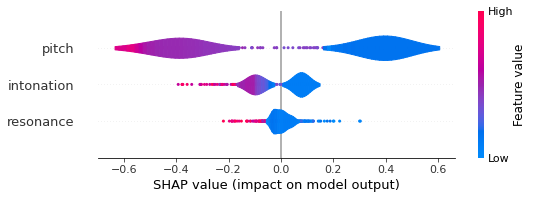

In [119]:
shap.summary_plot(shap_test, plot_type='violin')

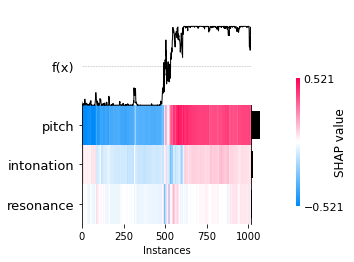

In [58]:
shap.plots.heatmap(shap_test)

In [94]:
shap.initjs()
# shap.force_plot(shap_test.base_values, shap_test.values, X_test)
shap.force_plot(explainer.expected_value[0], shap_test.values, X_test)
# explainer.expected_value[0].shape, shap_test.values[0].shape

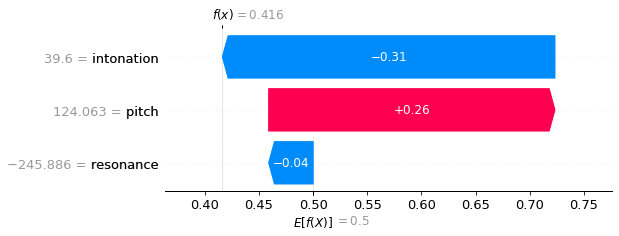

In [124]:
class WaterfallData():
    def __init__ (self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values.mean()
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
shap.plots.waterfall(WaterfallData(shap_test, 135))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:

# Hyperparameter Optimization

rf_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, *range(1, 10, 2)],
    'min_samples_leaf': [*range(1, 10, 2)],
    'max_features': [2, 3]
}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, rf_params, verbose=1)

rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_) # {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5}
preds = rf_cv.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0     0.9576    0.9576    0.9576       519
           1     0.9559    0.9559    0.9559       499

    accuracy                         0.9568      1018
   macro avg     0.9568    0.9568    0.9568      1018
weighted avg     0.9568    0.9568    0.9568      1018

[[497  22]
 [ 22 477]]


In [24]:

xgbc = xgb.XGBClassifier()

xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9578    0.9615    0.9596       519
           1     0.9598    0.9559    0.9578       499

    accuracy                         0.9587      1018
   macro avg     0.9588    0.9587    0.9587      1018
weighted avg     0.9587    0.9587    0.9587      1018

[[499  20]
 [ 22 477]]


In [35]:

gnb = GaussianNB()

gnb.fit(X_train, y_train)
preds = gnb.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9491    0.9692    0.9590       519
           1     0.9672    0.9459    0.9564       499

    accuracy                         0.9578      1018
   macro avg     0.9581    0.9575    0.9577      1018
weighted avg     0.9580    0.9578    0.9577      1018

[[503  16]
 [ 27 472]]


In [36]:
ridge_params = {
    'alpha': [i / 16 for i in range(1, 11)]
}
ridge = RidgeClassifier()
ridge_cv = GridSearchCV(ridge, ridge_params, verbose=1)

ridge.fit(X_train, y_train)
# print(ridge_cv.best_params_)
preds = ridge.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9723    0.9461    0.9590       519
           1     0.9454    0.9719    0.9585       499

    accuracy                         0.9587      1018
   macro avg     0.9588    0.9590    0.9587      1018
weighted avg     0.9591    0.9587    0.9587      1018

[[491  28]
 [ 14 485]]


In [89]:
logreg_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [i / 16 for i in range(1, 11)],
    'max_iter': [100_000]
}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, logreg_params, verbose=1)

logreg.fit(X_train, y_train)
# print(logreg_cv.best_params_) # {'C': 0.0625, 'max_iter': 100000, 'penalty': 'l2'}
preds = logreg.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9539    0.9395    0.9467       529
           1     0.9356    0.9509    0.9432       489

    accuracy                         0.9450      1018
   macro avg     0.9448    0.9452    0.9449      1018
weighted avg     0.9451    0.9450    0.9450      1018

[[497  32]
 [ 24 465]]


In [134]:
lsvc = LinearSVC()
norm_lsvc = Pipeline([('scaler', StandardScaler()), ('lsvc', LinearSVC())])

lsvc.fit(X_train, y_train)
preds = lsvc.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

In [33]:
svc_params = [
    {
        'C': [i / 4 for i in range(1, 11)],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
    },
    # {
    #     'C': [i / 4 for i in range(1, 6)],
    #     'kernel': ['poly'],
    #     'degree': [*range(2, 5)],
    #     'gamma': ['scale', 'auto'],
    # }
]
svc = SVC()
svc_cv = GridSearchCV(svc, svc_params, verbose=1, n_jobs=-1)

svc_cv.fit(X_train, y_train)
print(svc_cv.best_params_)
preds = svc_cv.predict(X_test)

print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0     0.9668    0.9538    0.9602       519
           1     0.9526    0.9659    0.9592       499

    accuracy                         0.9597      1018
   macro avg     0.9597    0.9598    0.9597      1018
weighted avg     0.9598    0.9597    0.9597      1018

[[495  24]
 [ 17 482]]


In [23]:
rf = RandomForestClassifier(
    criterion='entropy',
    max_features=2,
    min_samples_leaf=5
) # {'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 5}

models = [rf, xgbc, svc, gnb, logreg, ridge]

for m in models:
    cv_score = cross_val_score(m, X, y, cv=10, scoring=make_scorer(f1_score, average='weighted'))
    print(f'{m.__class__}: {round(cv_score.mean(), 4)} +/- {round(cv_score.std(), 4)}')
    cv_score = cross_val_score(m, X, y, cv=10, scoring=make_scorer(roc_auc_score, average='weighted'))
    print(f'{m.__class__}: {round(cv_score.mean(), 4)} +/- {round(cv_score.std(), 4)}')

<class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9511 +/- 0.0082
<class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9525 +/- 0.0097
